In [2]:
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

sns.set()

In [27]:
# Pull data from yfinance and save it into memory and disk

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override(tickers="JPM", period = '1d', start='2012-01-01', end='2017-12-31')
df_full = pdr.get_data_yahoo("JPM", start="2012-01-01", end='2017-12-31').reset_index()

yf.pdr_override(tickers="JPM", period = '1d', start='2018-01-01', end='2019-12-31')
df_full_test = pdr.get_data_yahoo("JPM", start="2018-01-01", end='2019-12-31').reset_index()

df_full.to_csv('data_raw/JPM_2012_2018.csv',index=False)
df_full_test.to_csv('data_raw/JPM_2018_2020.csv', index=False)

df_full.head()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,35.189999,34.009998,34.060001,34.980000,44102800.0,25.737314
1,2012-01-04,35.150002,34.330002,34.439999,34.950001,36571200.0,25.900341
2,2012-01-05,35.919998,34.400002,34.709999,35.680000,38381400.0,26.441322
3,2012-01-06,35.770000,35.139999,35.689999,35.360001,33160600.0,26.204189
4,2012-01-09,35.680000,34.990002,35.439999,35.299999,23001800.0,26.159719


In [233]:
df_full = pd.read_csv('data_raw/JPM_2012_2018.csv')
df_full_test = pd.read_csv('data_raw/JPM_2018_2020.csv')

## Stacked Decision Tree Ensembles using XGBoost and Encoded Features (EXGBEF)

In [246]:
# Generate date_ori which is used later for the visualization

date_ori = pd.to_datetime(df_full.iloc[:, 0]).tolist()
date_ori_test = pd.to_datetime(df_full_test.iloc[:, 0]).tolist()
df_full.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,35.189999,34.009998,34.060001,34.980000,44102800.0,25.737314
1,2012-01-04,35.150002,34.330002,34.439999,34.950001,36571200.0,25.900341
2,2012-01-05,35.919998,34.400002,34.709999,35.680000,38381400.0,26.441322
3,2012-01-06,35.770000,35.139999,35.689999,35.360001,33160600.0,26.204189
4,2012-01-09,35.680000,34.990002,35.439999,35.299999,23001800.0,26.159719


In [275]:
# Fit the normalization function then apply it to our data to get a normalized version
# This is the area that has caused the most trouble
# If we scale using the max/min of only the train dataset, then the test dataset will clip off values at the top (since the test-max > train-max)
# If we scale using max/min of both datasets, then the XGB model will only generate outputs up to the normalized max of the train dataset
# So, we must normalize them separately so each dataset has a similar range from 0 to 1

# adj_combined = pd.concat([df_full.loc[:, 'Adj Close'], df_full_test.loc[:, 'Adj Close']])

minmax_train = MinMaxScaler().fit(df_full.loc[:,'Adj Close'].values.reshape((-1,1)))
close_normalize = minmax_train.transform(df_full.loc[:,"Adj Close"].values.reshape((-1,1))).reshape((-1))
minmax_test = MinMaxScaler().fit(df_full_test.loc[:,'Adj Close'].values.reshape((-1,1)))
close_normalize_test = minmax_test.transform(df_full_test.loc[:, "Adj Close"].values.reshape((-1,1))).reshape((-1))

# Function that generates close price using normalized close.
def reverse_close_train(array):
    return minmax_train.inverse_transform(array.reshape((-1,1))).reshape((-1))
def reverse_close_test(array):
    return minmax_test.inverse_transform(array.reshape((-1,1))).reshape((-1))

In [276]:
print(f'{close_normalize.max()=}\n{close_normalize.min()=}\n{close_normalize.mean()=}')
print(f'{close_normalize_test.max()=}\n{close_normalize_test.min()=}\n{close_normalize_test.mean()=}')

close_normalize.max()=1.0
close_normalize.min()=0.0
close_normalize.mean()=0.3861863363667052
close_normalize_test.max()=1.0
close_normalize_test.min()=0.0
close_normalize_test.mean()=0.4020673473049032


In [277]:
### Creating features through an encoder
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.compat.v1.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.compat.v1.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.compat.v1.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.compat.v1.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.compat.v1.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.compat.v1.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.compat.v1.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.compat.v1.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.compat.v1.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

In [278]:
# Fit the encoder to our train data and generate a thought vector for the train data

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector_test = Encoder.encode(close_normalize_test.reshape((-1,1)))
thought_vector_test.shape, thought_vector.shape, close_normalize.shape

c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.20033868 time: 0.01007223129272461
epoch: 20 loss: 0.20033863 time: 0.0010466575622558594
epoch: 30 loss: 0.20033856 time: 0.0
epoch: 40 loss: 0.20033844 time: 0.0
epoch: 50 loss: 0.2003382 time: 0.008818864822387695
epoch: 60 loss: 0.20033778 time: 0.006995439529418945
epoch: 70 loss: 0.20033708 time: 0.007002353668212891
epoch: 80 loss: 0.20033585 time: 0.0045566558837890625
epoch: 90 loss: 0.20033363 time: 0.0
epoch: 100 loss: 0.20032926 time: 0.0


((503, 32), (1509, 32), (1509,))

In [279]:
# Initialize our Level 1 models

from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

### Original Parent Paper code
Note:
This didn't actually implement stacked learning since the level 2 training matrix was generated without k-folding of the training data.
We have included it here to illustrate the changes we made.

In [280]:
# Fit our Level 1 models to our train data 

ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(n_estimators=500)

In [281]:
# Assembling level 2 training matrix from level 1 model predictions

ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual]).T
corr_df = pd.DataFrame(stack_predict)

In [282]:
# Training level 2 model

import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, objective='reg:logistic', predictor='auto', ...)

In [283]:
clf.feature_importances_

array([8.9213639e-01, 3.2964800e-02, 6.9183894e-02, 5.0848685e-03,
       6.3001295e-04], dtype=float32)

In [284]:
# Assembling level 2 predictions and corresponding date series

xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

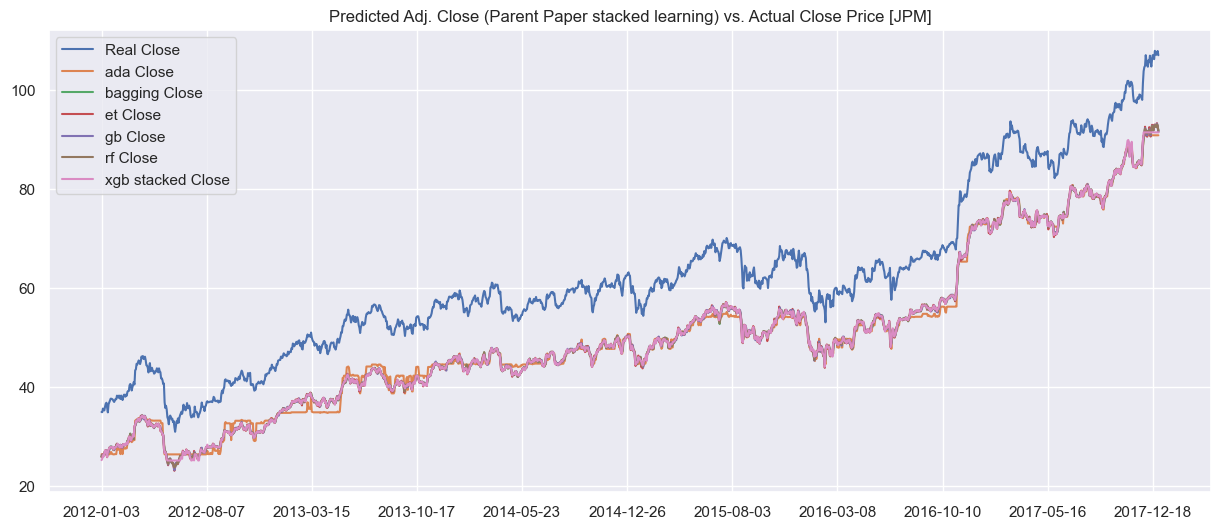

In [285]:
# Display parent paper train actual vs predicted

plt.figure(figsize = (15,6))
x_range = np.arange(df_full.Close.shape[0])
plt.plot(x_range, df_full.Close, label = 'Real Close')
plt.plot(x_range, reverse_close_train(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close_train(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close_train(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close_train(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close_train(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close_train(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::150], date_original[::150])
plt.title('Predicted Adj. Close (Parent Paper stacked learning) vs. Actual Close Price [JPM]')
plt.show()

In [286]:
from sklearn.metrics import mean_squared_error

print('MSE: ' + str(mean_squared_error(df_full.loc[:,'Adj Close'], reverse_close_train(xgb_pred))))

MSE: 0.33088766883705445


In [287]:
# Generating predictions for test data
# Note: I don't know why the variable xgb_actual_test is created. It just ends up being a day delayed from the Close price it's trying to predict

ada_pred=ada.predict(thought_vector_test)
bagging_pred=bagging.predict(thought_vector_test)
et_pred=et.predict(thought_vector_test)
gb_pred=gb.predict(thought_vector_test)
rf_pred=rf.predict(thought_vector_test)
ada_actual = np.hstack([close_normalize_test[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize_test[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize_test[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize_test[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize_test[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual]).T
xgb_pred_test = clf.predict(stack_predict)
xgb_actual_test = np.hstack([close_normalize_test[0],xgb_pred_test[:-1]])
date_original_test=pd.Series(date_ori_test).dt.strftime(date_format='%Y-%m-%d').tolist()


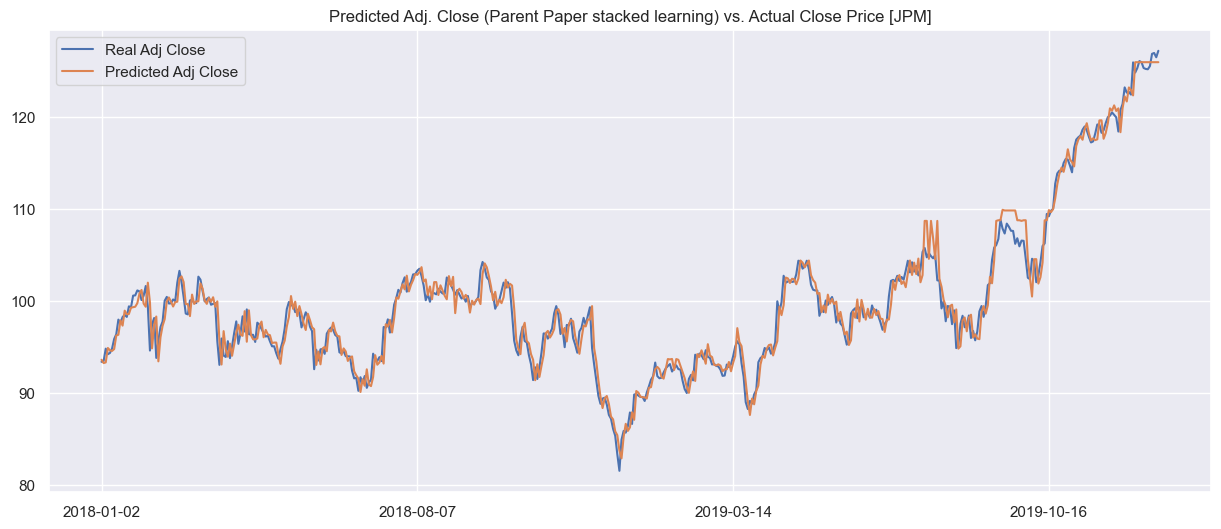

In [288]:
# Display parent paper test actual vs predicted

plt.figure(figsize = (15,6))
x_range_test = np.arange(df_full_test.loc[:,'Adj Close'].shape[0])
plt.plot(x_range_test, df_full_test.loc[:,'Adj Close'], label = 'Real Adj Close')
plt.plot(x_range_test, reverse_close_test(xgb_pred_test), label = 'Predicted Adj Close')
plt.legend()
plt.xticks(x_range_test[::150], date_original_test[::150])
plt.title('Predicted Adj. Close (Parent Paper stacked learning) vs. Actual Close Price [JPM]')
plt.show()

In [292]:
from sklearn.metrics import mean_squared_error

print('MSE: ' + str(mean_squared_error(df_full_test.loc[:,'Adj Close'], reverse_close_test(xgb_pred_test))))
print('Score: ' + str(clf.score(stack_predict, close_normalize_test)))

clf.save_model('results/parent_paper_clf.json')

MSE: 2.0773681402636925
Score: 0.9694608415406422


### New Project Code

In [293]:
# Initialize our Level 1 models

from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

In [294]:
# Using k-folding to assemble level 2 training matrix
# Note: Should we include previous day close price as part of the training matrix?
# 		If we do, that is the actual array variable seen below.

ada_pred=np.array([])
bagging_pred=np.array([])
et_pred=np.array([])
gb_pred=np.array([])
rf_pred=np.array([])
actual=np.array([])
next_day=np.array([])

trimmed_tv = thought_vector[:-1,:]
trimmed_close = close_normalize[1:]

k=10
i=0
from sklearn.model_selection import KFold
for train_i, test_i in KFold(k, shuffle=True).split(trimmed_tv):
	i = i+1
	print(f'Processing fold\t{i}/{k}', end='\t')
	print('ada', end='\t')
	ada.fit(trimmed_tv[train_i], close_normalize[train_i+1])
	print('bagging', end='\t')
	bagging.fit(trimmed_tv[train_i], close_normalize[train_i+1])
	print('et', end='\t')
	et.fit(trimmed_tv[train_i], close_normalize[train_i+1])
	print('gb', end='\t')
	gb.fit(trimmed_tv[train_i], close_normalize[train_i+1])
	print('rf', end='\t')
	rf.fit(trimmed_tv[train_i], close_normalize[train_i+1])
	print('\tTrain done')
	ada_pred = np.hstack([ada_pred, ada.predict(trimmed_tv[test_i])])
	bagging_pred = np.hstack([bagging_pred, bagging.predict(trimmed_tv[test_i])])
	et_pred = np.hstack([et_pred, et.predict(trimmed_tv[test_i])])
	gb_pred = np.hstack([gb_pred, gb.predict(trimmed_tv[test_i])])
	rf_pred = np.hstack([rf_pred, rf.predict(trimmed_tv[test_i])])
	actual = np.hstack([actual, close_normalize[test_i]])
	next_day = np.hstack([next_day, close_normalize[test_i+1]])

stacked_pred = np.vstack([ada_pred, bagging_pred, et_pred, gb_pred, rf_pred]).T
train_Y = next_day.T
corr_df = pd.DataFrame(stacked_pred, columns=['ada', 'bagging', 'et', 'gb', 'rf'])

Processing fold	1/10	ada	bagging	et	gb	rf		Train done
Processing fold	2/10	ada	bagging	et	gb	rf		Train done
Processing fold	3/10	ada	bagging	et	gb	rf		Train done
Processing fold	4/10	ada	bagging	et	gb	rf		Train done
Processing fold	5/10	ada	bagging	et	gb	rf		Train done
Processing fold	6/10	ada	bagging	et	gb	rf		Train done
Processing fold	7/10	ada	bagging	et	gb	rf		Train done
Processing fold	8/10	ada	bagging	et	gb	rf		Train done
Processing fold	9/10	ada	bagging	et	gb	rf		Train done
Processing fold	10/10	ada	bagging	et	gb	rf		Train done


In [296]:
pd.DataFrame(np.vstack([stacked_pred[:,i] for i in range(stacked_pred.shape[1])] + [actual] + [next_day]).T, columns=['ada', 'bagging', 'et', 'gb', 'rf', 'actual', 'next_day']).head(50)

,ada,bagging,et,gb,rf,actual,next_day
0,0.074894,0.065594,0.066970,0.060822,0.065735,0.059650,0.049827
1,0.074894,0.067052,0.066824,0.068894,0.066925,0.066410,0.063453
2,0.074894,0.076189,0.075857,0.074073,0.076039,0.073276,0.070424
3,0.074894,0.071467,0.070952,0.072678,0.071519,0.074966,0.070319
4,0.074894,0.072452,0.073276,0.073009,0.072514,0.074755,0.082994
5,0.148862,0.144823,0.143395,0.141825,0.144540,0.141833,0.137048
6,0.150896,0.146791,0.147019,0.148489,0.146516,0.147149,0.129818
7,0.095134,0.131376,0.129651,0.129208,0.131257,0.127373,0.135985
8,0.074894,0.031294,0.025939,0.027659,0.031056,0.016055,0.032003
9,0.074894,0.027628,0.022009,0.022178,0.027615,0.009888,0.000000


In [307]:
# Training level 2 model

import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }

clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stacked_pred, train_Y, eval_set=[(stacked_pred, train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Mine\School\Fall2022\ds340w\DS340W\env\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, objective='reg:logistic', predictor='auto', ...)

In [222]:
# Fitting final level 1 models (w/o k-folding)

ada.fit(trimmed_tv, close_normalize[1:])
bagging.fit(trimmed_tv, close_normalize[1:])
et.fit(trimmed_tv, close_normalize[1:])
gb.fit(trimmed_tv, close_normalize[1:])
rf.fit(trimmed_tv, close_normalize[1:])

RandomForestRegressor(n_estimators=500)

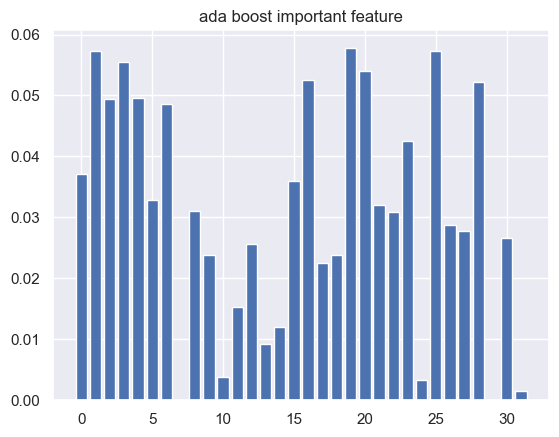

In [308]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

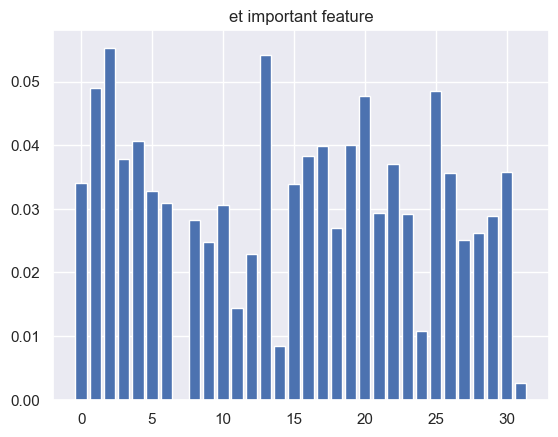

In [309]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

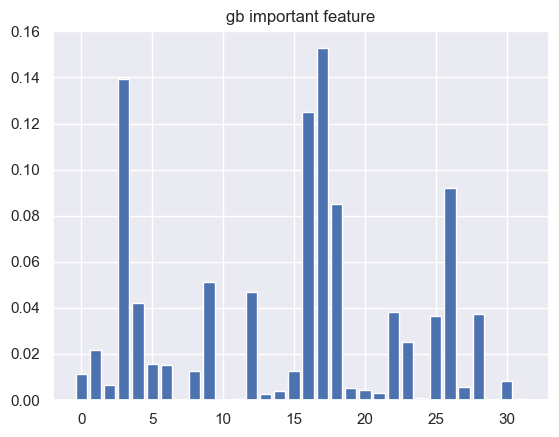

In [310]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

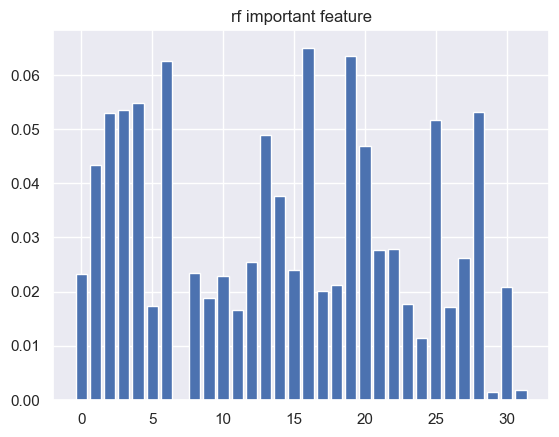

In [311]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [312]:
# Correlation heat map
# Note: This should have more varied values throughout
corr_df.corr()


# sns.heatmap(corr_df.corr(), annot=True)
# plt.show()

,ada,bagging,et,gb,rf
ada,1.000000,0.997740,0.997526,0.997804,0.997738
bagging,0.997740,1.000000,0.999910,0.999900,0.999998
et,0.997526,0.999910,1.000000,0.999800,0.999908
gb,0.997804,0.999900,0.999800,1.000000,0.999897
rf,0.997738,0.999998,0.999908,0.999897,1.000000


In [313]:
# Generate predictions for validation (unseen) data
# Very similar to earlier, except different names and no training (i.e. fit) step, only predictions

ada_pred_test=ada.predict(thought_vector_test)
bagging_pred_test=bagging.predict(thought_vector_test)
et_pred_test=et.predict(thought_vector_test)
gb_pred_test=gb.predict(thought_vector_test)
rf_pred_test=rf.predict(thought_vector_test)
ada_actual_test = np.hstack([close_normalize_test[0],ada_pred_test[:-1]])
bagging_actual_test = np.hstack([close_normalize_test[0],bagging_pred_test[:-1]])
et_actual_test = np.hstack([close_normalize_test[0],et_pred_test[:-1]])
gb_actual_test = np.hstack([close_normalize_test[0],gb_pred_test[:-1]])
rf_actual_test = np.hstack([close_normalize_test[0],rf_pred_test[:-1]])
stack_predict_test = np.vstack([ada_actual_test,bagging_actual_test,et_actual_test,gb_actual_test,rf_actual_test]).T
corr_df_test = pd.DataFrame(stack_predict_test)
xgb_pred_test = clf.predict(stack_predict_test)
xgb_actual_test = np.hstack([close_normalize_test[0],xgb_pred_test[:-1]])
date_original_test=pd.Series(date_ori_test).dt.strftime(date_format='%Y-%m-%d').tolist()

In [314]:
print(f'{xgb_pred_test.mean()=}')
print(f'{xgb_pred_test.max()=}')
print(f'{xgb_pred_test.min()=}')
print(f'{close_normalize.max()=}')
print(f'{close_normalize.min()=}')
print(f'{close_normalize_test.max()=}')
print(f'{close_normalize_test.min()=}')

xgb_pred_test.mean()=0.4030792
xgb_pred_test.max()=0.9728679
xgb_pred_test.min()=0.033333514
close_normalize.max()=1.0
close_normalize.min()=0.0
close_normalize_test.max()=1.0
close_normalize_test.min()=0.0


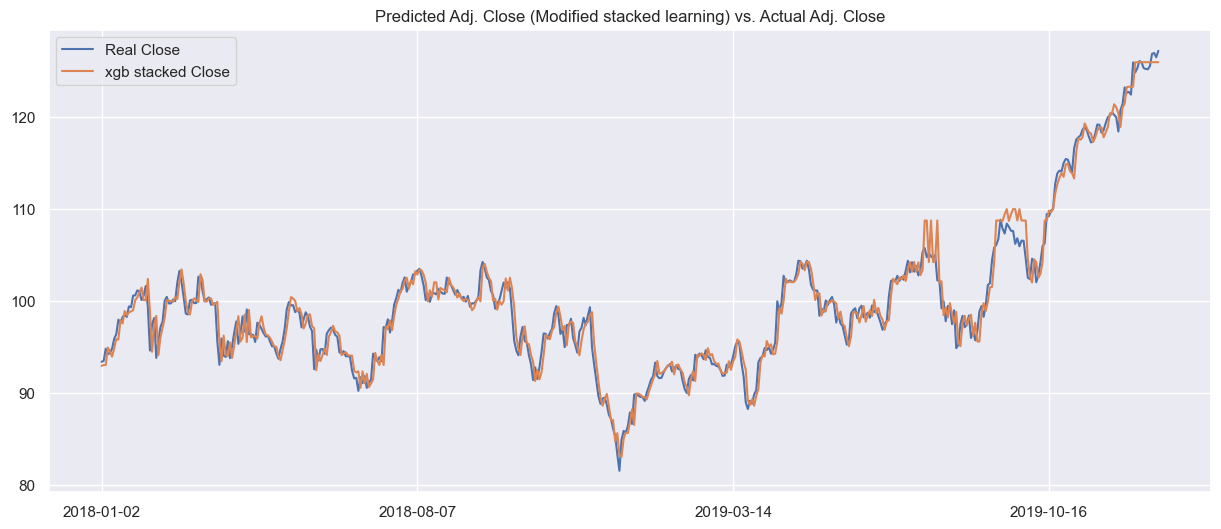

In [315]:
plt.figure(figsize = (15,6))
x_range_test = np.arange(df_full_test.loc[:, 'Adj Close'].shape[0])
plt.plot(x_range_test, df_full_test.loc[:, 'Adj Close'], label = 'Real Close')
plt.plot(x_range_test, reverse_close_test(xgb_pred_test), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_test[::150], date_original_test[::150])
plt.title('Predicted Adj. Close (Modified stacked learning) vs. Actual Adj. Close')
plt.show()

In [316]:
from sklearn.metrics import mean_squared_error

print('MSE: ' + str(mean_squared_error(df_full_test.loc[:,'Adj Close'], reverse_close_test(xgb_pred_test))))
print('Score: ' + str(clf.score(stack_predict_test, close_normalize_test)))

clf.save_model('results/modified_clf.json')

MSE: 1.9709480933533319
Score: 0.9710253095678907


Everything below is garbage code. Ignore.

In [ ]:
# I don't even know what this does

ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()
def predict(count, history = 5):
    for i in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1,1)))
        ada_pred=ada.predict(thought_vector)
        bagging_pred=bagging.predict(thought_vector)
        et_pred=et.predict(thought_vector)
        gb_pred=gb.predict(thought_vector)
        rf_pred=rf.predict(thought_vector)
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])
        ada_actual = np.hstack([xgb_list[-history],ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history],bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history],et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history],gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history],rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1]+timedelta(days=1))

In [ ]:
predict(30, history = 5)

In [317]:
plt.figure(figsize = (15,6))
x_range = np.arange(df_full.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df_full.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close_train(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close_train(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close_train(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close_train(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close_train(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close_train(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::150], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::150])
plt.title('stacked')
plt.show()

NameError: name 'xgb_list' is not defined

<Figure size 1500x600 with 0 Axes>

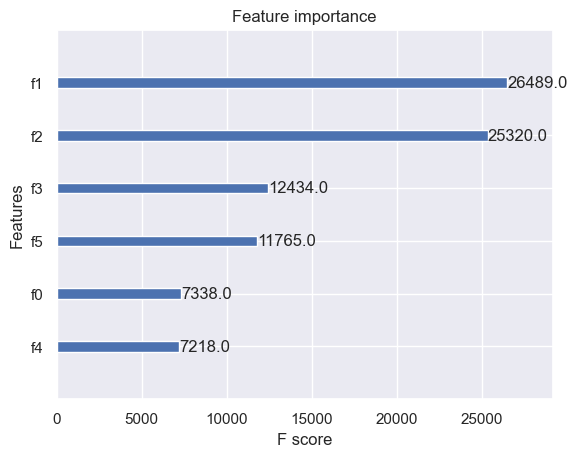

In [ ]:
### Arima Slightly more important than RNN, but clearly overfits (most likley represents lagged close more than anything else)
from xgboost import plot_importance
plot_importance(clf)
plt.show()